In [98]:
from __future__ import print_function, division
from builtins import range

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

print(os.listdir("../input"))

['jigsaw-toxic-comment-classification-challenge', 'glove6b100dtxt']


In [99]:
max_sequence_length = 100
max_vocab_size = 20000
embedding_dim = 100
validation_split = 0.2
batch_size = 128
epochs = 10

In [100]:
word2vec = {}
f = open('../input/glove6b100dtxt/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print(len(word2vec))


400000


In [101]:
train = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [102]:
# read in the training data
sentences = train["comment_text"].fillna("DUMMY_VAL").values

# here we get the 0/1 value for each label in the dataset (do all of them at once) for all rows
possible_labels = ['toxic', 'severe_toxic','obscene','threat','insult','identity_hate']
targets = train[possible_labels].values

In [103]:
print(max(len(s) for s in sentences))
print(min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print(s[len(s) // 2])

5000
6
205


In [104]:
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [105]:
word2index = tokenizer.word_index
print(len(word2index))

210337


In [106]:
data = pad_sequences(sequences, maxlen=max_sequence_length)
print(data.shape)

(159571, 100)


In [107]:
num_words = min(max_vocab_size, len(word2index)+1)
print(num_words, max_vocab_size)

20000 20000


In [108]:
# load the embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

for word,i in  word2index.items():
    if i < max_vocab_size:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
         # words not in the glove will be set to zero   
            embedding_matrix[i] = embedding_vector

In [109]:
embedding_layer = Embedding(
num_words,
embedding_dim, 
weights = [embedding_matrix],
input_length=max_sequence_length,
trainable=False )# we set trainable to false so the weights will stay same during training

In [110]:
input_ = Input(shape=(max_sequence_length, ))
x = embedding_layer(input_)
# return_sequences=True : shows last result and there is no reason for pooling best feature
# x = LSTM(15, return_sequences=True)(x)  # 98% accuracy

In [111]:
# this increases the quality of results slightly (less than 1%)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)

In [112]:
output = Dense(len(possible_labels), activation="sigmoid")(x)
model = Model(input_, output)
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.01), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 30)           13920     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 186       
Total params: 2,014,106
Trainable params: 14,106
Non-trainable params: 2,000,000
_________________________________________________________________


In [113]:
r = model.fit(data, targets, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 134s 1ms/step - loss: 0.0688 - acc: 0.9769 - val_loss: 0.0564 - val_acc: 0.9801
Epoch 2/10
127656/127656 [==============================] - 129s 1ms/step - loss: 0.0535 - acc: 0.9810 - val_loss: 0.0549 - val_acc: 0.9804
Epoch 3/10
127656/127656 [==============================] - 129s 1ms/step - loss: 0.0511 - acc: 0.9815 - val_loss: 0.0537 - val_acc: 0.9808
Epoch 4/10
127656/127656 [==============================] - 127s 995us/step - loss: 0.0497 - acc: 0.9820 - val_loss: 0.0529 - val_acc: 0.9810
Epoch 5/10
127656/127656 [==============================] - 129s 1ms/step - loss: 0.0485 - acc: 0.9823 - val_loss: 0.0516 - val_acc: 0.9811
Epoch 6/10
127656/127656 [==============================] - 127s 994us/step - loss: 0.0474 - acc: 0.9827 - val_loss: 0.0518 - val_acc: 0.9812
Epoch 7/10
127656/127656 [==============================] - 127s 997us/step - loss: 0.0469 - acc: 0.9827 

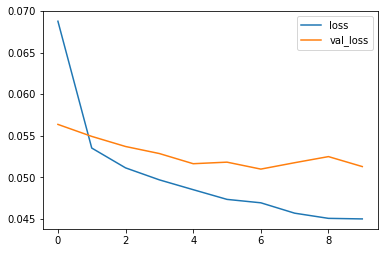

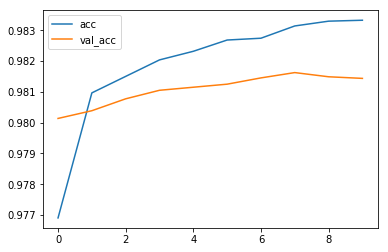

In [114]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label='acc')#
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [115]:
test = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv")
test.head()

sentences_t = test["comment_text"]

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(sentences_t)
sequences_t = tokenizer.texts_to_sequences(sentences_t)

In [116]:
d = pad_sequences(sequences_t, maxlen=max_sequence_length)

In [117]:
res = model.predict(d, batch_size=batch_size, verbose=1)

153164/153164 [==============================] - 51s 333us/step


In [118]:
res = [[1 if num > 0.5 else 0 for num in arr] for arr in res]

In [119]:
cols = ['id', 'toxic', 'severe_toxic','obscene','threat','insult','identity_hate']
final = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv")
ids = final.id
for i,arr in enumerate(res):
    arr.insert(0, ids[i])

AssertionError: 6 columns passed, passed data had 7 columns

In [122]:
my_submission = pd.DataFrame(res, columns=cols)
my_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1,0,1,0,0,0
1,0000247867823ef7,1,0,1,0,1,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,0,0,0,0,0,0
9,00026d1092fe71cc,0,0,0,0,0,0


In [123]:
my_submission.to_csv('submission.csv', index=False)